In [ ]:
"""
input
- 출발 지하철 역
- 출발 지하철 노선 (except 경의중앙선, 분당선)
- 가는 방향 (상행선/하행선)

process
1. find next station

2. check and get current_station and next_station data
    - input 출발 (지하철 역 & 지하철 노선) 데이터가 있는지 확인
        -> 없다 추출
    - input 출발 (지하철 역 & 지하철 노선)의 다음역 데이터가 있는지 확인
        -> 없다 추출

3. informations
    - 출발역의 혼잡도 시간별 lineplot
    - 출발역의 칸별 시간별 heatmap
    - 출발역의 다음역 칸별 하차율 heatmap
"""

In [2]:
st_name = '공덕역'
st_line = '6호선'
direction = '상행선'
time_line = '출근시간'

In [3]:
# 1. find next station
import json
import pandas as pd

with open('metro_graph/metro_graph.json') as json_data:
    data = json.load(json_data)

df_metro_graph=pd.DataFrame(data['6']).loc[:,['from','to']]
df_metro_graph['from']=df_metro_graph['from'].apply(lambda x: x+'역')
df_metro_graph['to']=df_metro_graph['to'].apply(lambda x: x+'역')

# if 상행선 -> from 
# if 하행성 -> to
if direction == '상행선':
    st_name_next=df_metro_graph[df_metro_graph['from']==st_name]['to'].values[0]
if direction == '하행선':
    st_name_next=df_metro_graph[df_metro_graph['to']==st_name]['from'].values[0]

In [4]:
# 2. check and get current_station and next_station data

# imports
from glob import glob

# input params
stationname_li = [st_name,st_name_next]
dow_list=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']
hh_li = [str(i).zfill(2) for i in range(6,10)] + [str(i).zfill(2) for i in range(16,20)]

# st_name, st_code mapper
mapper=pd.read_csv('raw_data/StationCode_mapper.csv',index_col=0)

# check data
count = 0
need_to_get = list()
for stationname in stationname_li:
    for dow in dow_list:
        for hh in hh_li:
            station_code=mapper[(mapper['subwayLine']==st_line) & (mapper['stationName']==stationname)]['stationCode'].values[0]
            if len(glob(f'raw_data/??_{station_code}_{dow}_{hh}.json')) ==0:
                # print(f'{stationname}_{dow}_{hh}')
                need_to_get.append((stationname,dow,hh))
                count += 1
print(f'{count*3}번 api 호출')

# find only data doenst exist
print(set([i[0] for i in need_to_get]))
print(set([i[1] for i in need_to_get]))
print(set([i[2] for i in need_to_get]))

stationname_li = list(set([i[0] for i in need_to_get]))
dow_list=list(set([i[1] for i in need_to_get]))
hh_li = list(set([i[2] for i in need_to_get]))

0번 api 호출
set()
set()
set()


In [5]:
# get data
from _03_data_pipeline.data_pipeline import get_data

cnt = 0
for dow in dow_list:
    for stationname in stationname_li:
        for hh in hh_li:
            get_data(stationname,st_line,dow,hh)
            cnt += 1
print(f'{cnt*3}번 api 호출')

0번 api 호출


In [6]:
# 3. show information
import matplotlib.pyplot as plt
import seaborn as sns
from _04_data_eda.read_data import read_data, slice_time

df_1,df_2,df_3 = read_data(st_line,st_name)
df_1,df_2,df_3 = slice_time(df_1,time_line), slice_time(df_2,time_line), slice_time(df_3,time_line)
df_1['time'],df_2['time'],df_3['time']=df_1['time'].apply(lambda x : x.split()[-1][:-3]),\
                                       df_2['time'].apply(lambda x : x.split()[-1][:-3]),\
                                       df_3['time'].apply(lambda x : x.split()[-1][:-3])

df_1_next,df_2_next,df_3_next = read_data(st_line,st_name_next)
df_1_next,df_2_next,df_3_next = slice_time(df_1_next,time_line), slice_time(df_2_next,time_line), slice_time(df_3_next,time_line)
df_1_next['time'],df_2_next['time'],df_3_next['time']=df_1_next['time'].apply(lambda x : x.split()[-1][:-3]),\
                                                      df_2_next['time'].apply(lambda x : x.split()[-1][:-3]),\
                                                      df_3_next['time'].apply(lambda x : x.split()[-1][:-3])
                                                      
from _05_plots.draw_plots import plot_congest_station, plot_congest_sectional, plot_getoff_sectional

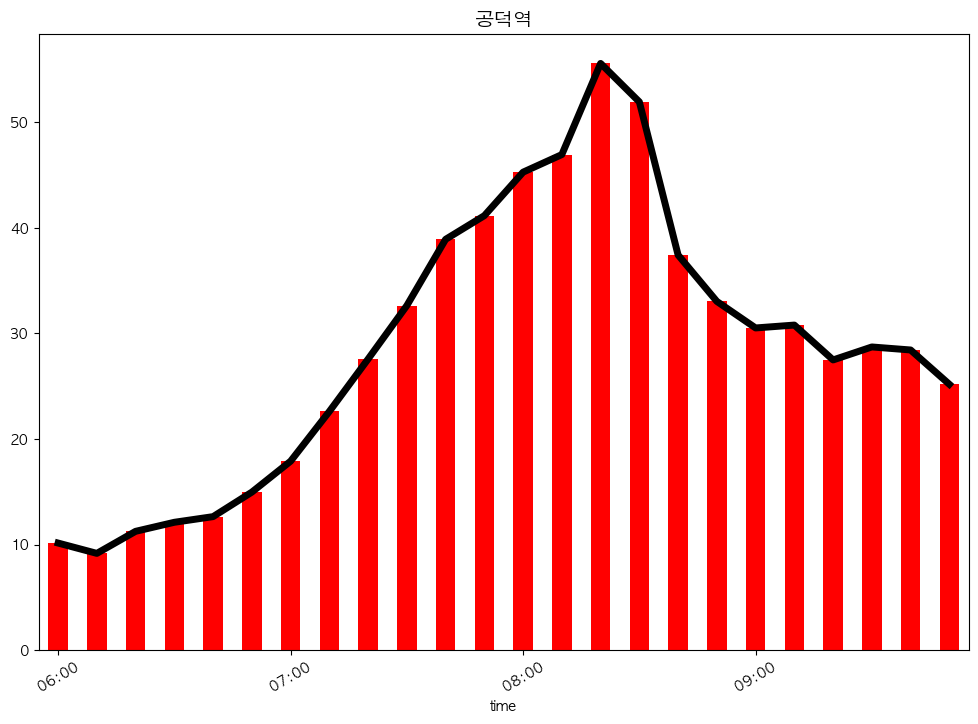

In [7]:
plot_congest_station(df_1)

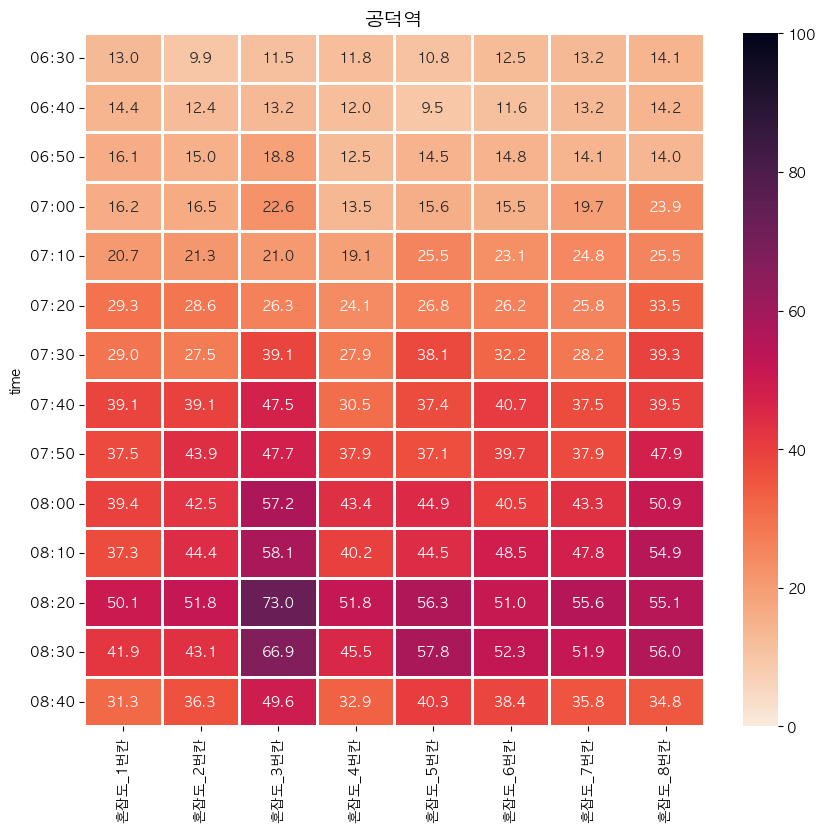

In [8]:
plot_congest_sectional(df_2)

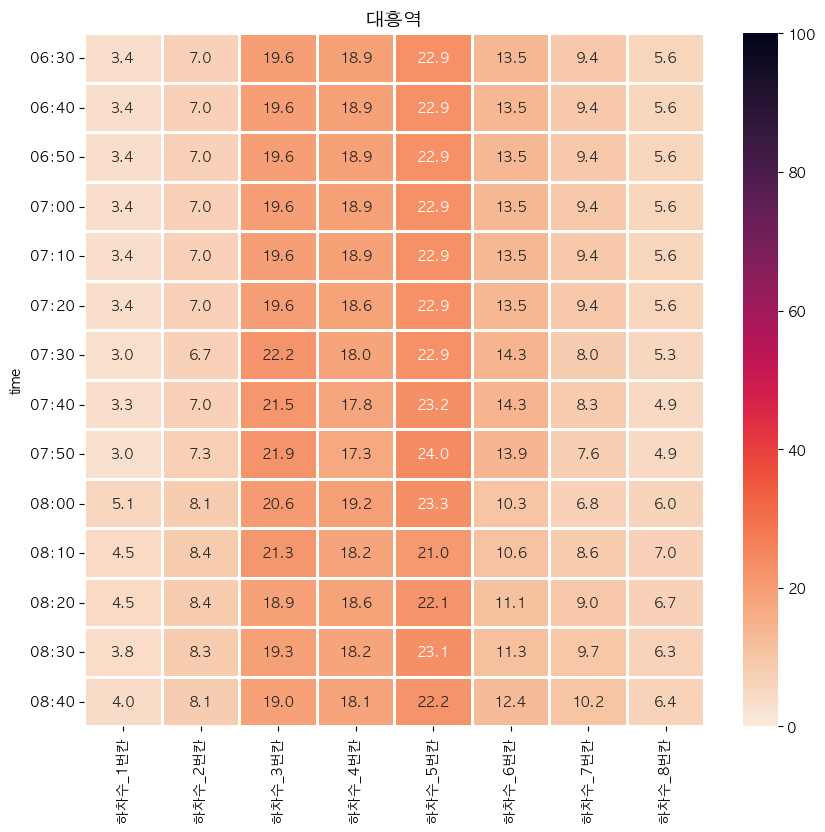

In [10]:
plot_getoff_sectional(df_3_next)